In [1]:
using JLD2
using CairoMakie
using FourierFlows
using GeophysicalFlows: MultiLayerQG

In [2]:
#initial_condition_file = jldopen("/scratch/nad9961/twolayer_simulation/49507852/initial_condition_512x512_U=1.00_freely_evolve.jld2")
#raytracing_initial_cond = jldopen("/home/nad9961/JuliaRaytracingSW/raytracing/initial_conditions/initial_condition_512x512_U=1.10_freely_evolve.jld2")
raytracing_initial_cond = jldopen("/scratch/nad9961/twolayer_simulation/45984910/initial_condition_512x512_U=1.10_freely_evolve.jld2")

JLDFile /scratch/nad9961/twolayer_simulation/45984910/initial_condition_512x512_U=1.10_freely_evolve.jld2 (read-only)
 ├─📂 eqn
 │  ├─🔢 L
 │  ├─🔢 dims
 │  └─🔢 T
 ├─📂 clock
 │  └─🔢 dt
 ├─📂 grid
 │  ├─🔢 nx
 │  └─ ⋯ (5 more entries)
 └─ ⋯ (2 more entries)

In [2]:
#diagnostics = jldopen("/scratch/nad9961/twolayer_simulation/45984910/diagnostic_file.jld2")
diagnostics = jldopen("/scratch/projects/shaferlab/nick/twolayer_simulation/50475856/diagnostic_file.jld2")
# lines(diagnostics["diagnostics/energy/t"], diagnostics["diagnostics/energy/data"])
energy = zeros(length(diagnostics["diagnostics/energy/steps"]), 3)
t = diagnostics["diagnostics/energy/t"]
[energy[i, :] = [k[1][1], k[1][2], k[2]] for (i,k) in enumerate(diagnostics["diagnostics/energy/data"])]
f = Figure()
ax = Axis(f[1,1], xlabel="ft", ylabel="Energy")
lines!(ax, t, energy[:,1], label="Top Layer KE", color="blue")
lines!(ax, t, energy[:,2], label="Bottom Layer KE", color="red")
lines!(ax, t, energy[:,3], label="PE", color="gray")
lines!(ax, t, sum(energy, dims=2)[:], label="Total", color="black", linewidth=3)

Legend(f[2, 1], ax, orientation=:horizontal)
f

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/MYcfT/src/JLD2.jl:298


LoadError: SystemError: opening file "/scratch/projects/shaferlab/nick/twolayer_simulation/50475856/diagnostic_file.jld2": No such file or directory

In [4]:
#file = initial_condition_file
file = raytracing_initial_cond

#ψh₀ = file["snapshots/ψh/543456"]
ψh₀ = file["snapshots/ψh/595404"]

#prob = 
Lx=file["grid/Lx"]
nx=file["grid/nx"]
f₀ = file["params/f₀"]
U = file["params/U"]
U = sum(U, dims=(1,2))[:]/size(U,1)/size(U,2)
H = file["params/H"]
H = [H[1], H[2]]
b = file["params/b"]
b = [b[1], b[2]]
ν = file["params/ν"]
nν = file["params/nν"]
prob = MultiLayerQG.Problem(2; nx, Lx, f₀, U, H, b, ν, nν)
grid = prob.grid

TwoDimensionalGrid
  ├───────────────── Device: CPU
  ├────────────── FloatType: Float64
  ├────────── size (Lx, Ly): (18.84955592153876, 18.84955592153876)
  ├──── resolution (nx, ny): (512, 512)
  ├── grid spacing (dx, dy): (0.03681553890925539, 0.03681553890925539)
  ├───────────────── domain: x ∈ [-9.42477796076938, 9.387962421860124]
  |                          y ∈ [-9.42477796076938, 9.387962421860124]
  └─ aliased fraction: 0.3333333333333333

In [5]:
qh = zeros(Complex{Float64}, grid.nkr, grid.nl, 2)
MultiLayerQG.pvfromstreamfunction!(qh, ψh₀, prob.params, grid)

q  = irfft(qh, grid.nx, (1, 2))
ψ  = irfft(ψh₀, grid.nx, (1, 2))
u  = irfft(-1im * grid.l  .* ψh₀, grid.nx, (1, 2))
v  = irfft( 1im * grid.kr .* ψh₀, grid.nx, (1, 2))
ux = irfft( grid.l  .* grid.kr .* ψh₀, grid.nx, (1, 2))
uy = irfft( grid.l  .* grid.l  .* ψh₀, grid.nx, (1, 2))
vx = irfft(-grid.kr .* grid.kr .* ψh₀, grid.nx, (1, 2))
vy = irfft(-grid.kr .* grid.l  .* ψh₀, grid.nx, (1, 2));

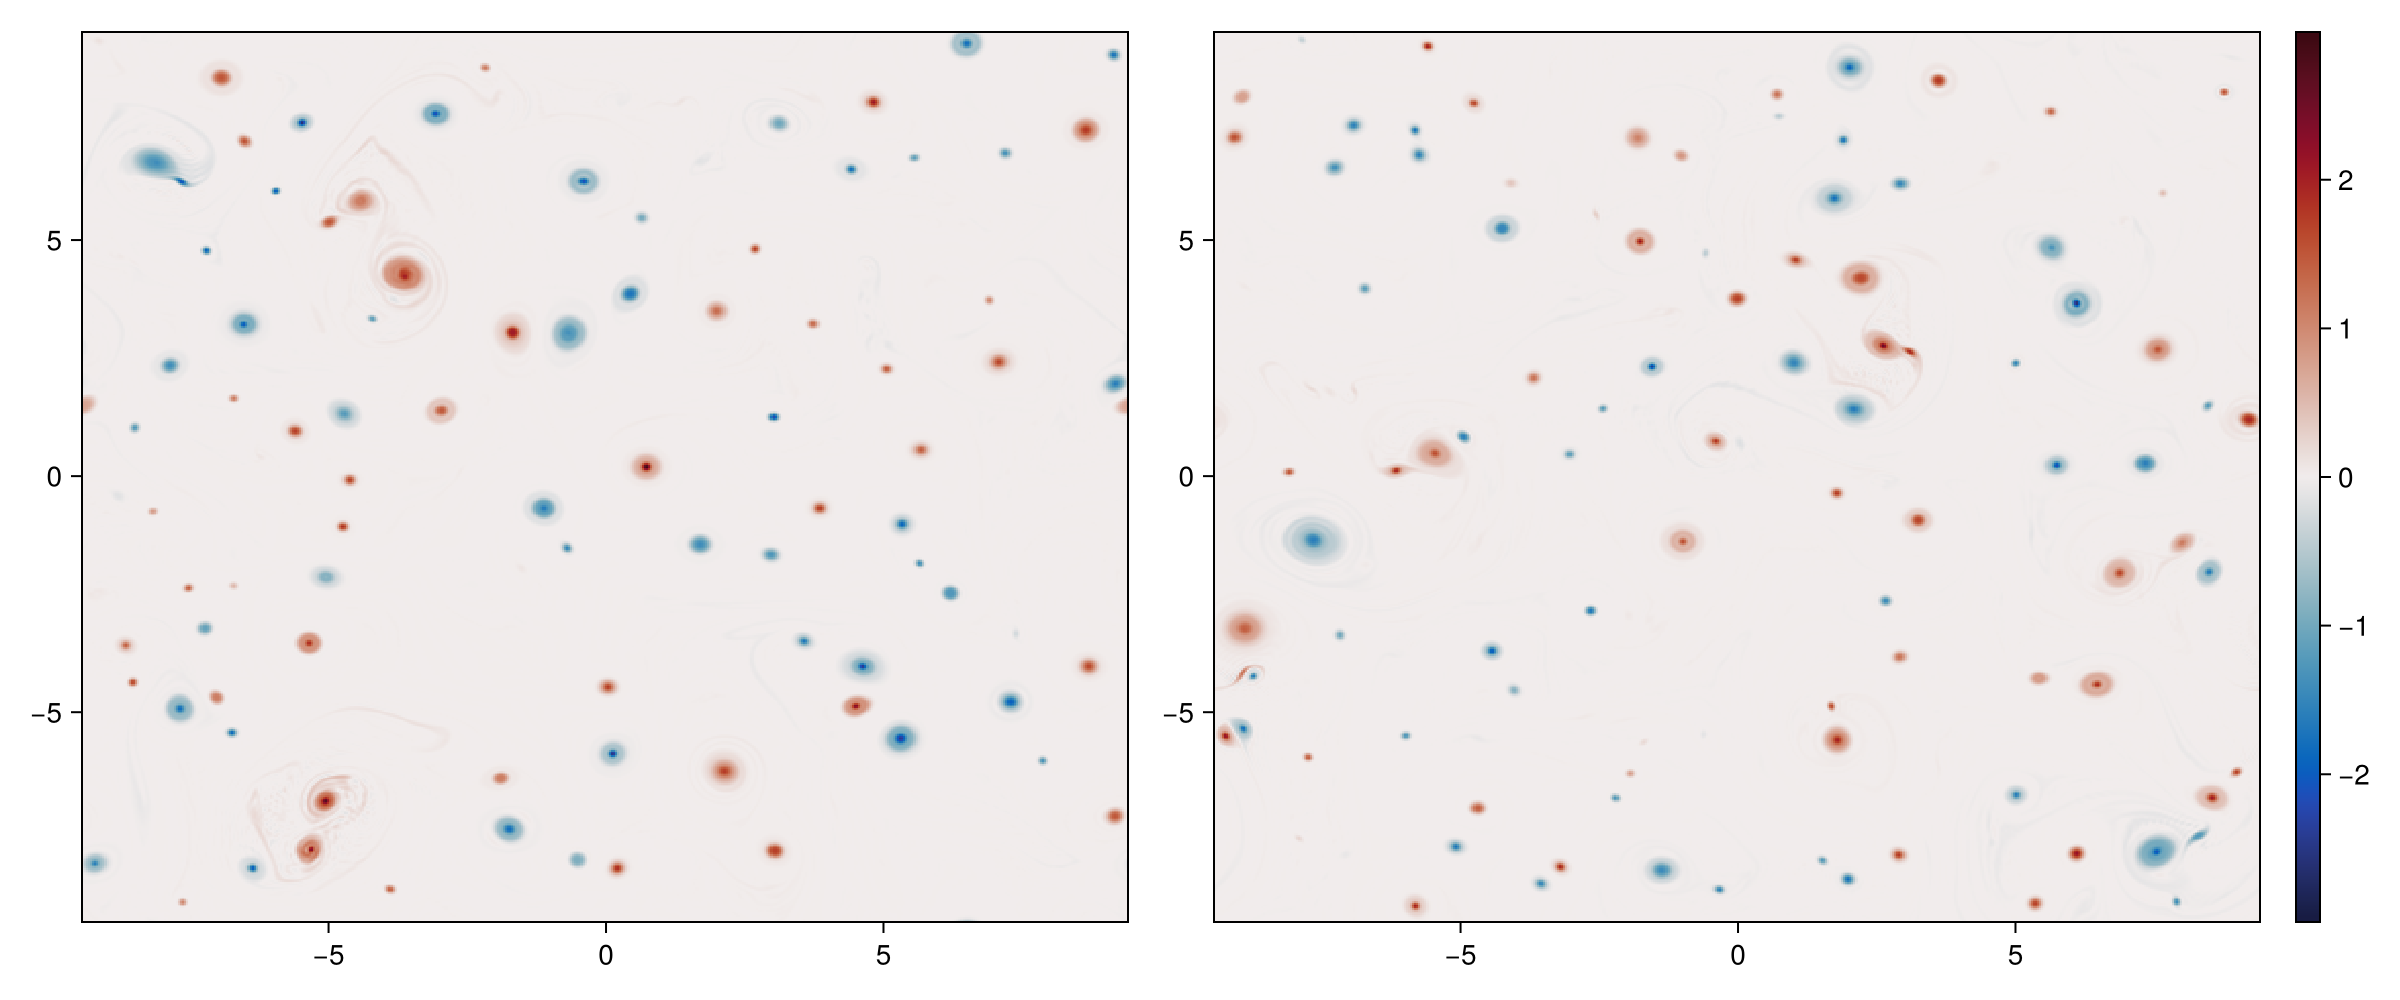

In [17]:
vxt = sum(vx, dims=3)[:,:,1]
uyt = sum(uy, dims=3)[:,:,1]
uxt = sum(ux, dims=3)[:,:,1]
vyt = sum(vy, dims=3)[:,:,1]
ζ  = vxt - uyt
σₛ = vxt + uyt
σₙ = uxt - vyt
σ = @. sqrt(σₛ^2 + σₙ^2)
fig = Figure(size=(1200, 500))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])
#hm = heatmap!(ax, σ.^2 - ζ.^2, colormap=:amp, colorrange = (0, 1), lowclip = :white)
q_max = maximum(abs.(q))
hm1 = heatmap!(ax1, grid.x, grid.y, q[:,:,1], colormap=:balance, colorrange=(-q_max, q_max))
hm2 = heatmap!(ax2, grid.x, grid.y, q[:,:,2], colormap=:balance, colorrange=(-q_max, q_max))
c = Colorbar(fig[1,3], hm1)
fig

In [7]:
# Let's analyze Shafer's parameters
function generate_initial_condition(a_g, K_band, L, N, Cg, f, wave_mode)
    K_max = ceil(Int, sqrt(2)*K_band[2])
    k = 0:K_max
    l = 0:K_max
    x = (((0:(N-1))/N) .- 0.5) * L
    y = x'
    η = zeros(N, N)
    u = zeros(N, N)
    v = zeros(N, N)
    for ki=k
        for lj=l
            if ki == 0 && lj == 0
                continue
            end
            K2 = ki^2 + lj^2
            if K_band[1]^2 <= K2 <= K_band[2]^2 
                rk = rand()
                phase = @. ki*x + lj*y + 2*π*rk
                η += @. cos(phase)
                if wave_mode
                    ω = @. sign(rk - 0.5) * sqrt(f^2 + Cg^2*K2)
                    u += @. (ki*ω*cos(phase) - lj*f*sin(phase))/K2
                    v += @. (lj*ω*cos(phase) + ki*f*sin(phase))/K2
                else
                    u += @.  (Cg^2/f)*lj*(sin(phase))
                    v += @. -(Cg^2/f)*ki*(sin(phase))
                end
            end
        end
    end
    η_max = maximum(η)
    Ag = a_g/η_max
    η *= Ag
    u *= Ag
    v *= Ag
    return η, u, v
end

function SW_energy(u, v, η, Cg)
    return @. η * (u^2 + v^2) + Cg^2*η^2
end

SW_energy (generic function with 1 method)

In [17]:
using Random: seed!
seed!(122)

L = 2π
N = 64
f = 3
Cg = 1

ηg, ug, vg = generate_initial_condition(0.3, (10, 13), L, N, Cg, f, false)
ηw, uw, vw = generate_initial_condition(0.1, (0, 5), L, N, Cg, f, true)
η = ηg + ηw
u = ug + uw
v = vg + vw

U = sqrt(maximum(u.^2 + v.^2))
println(U)
Ld = Cg/f

Ro = U/(f*Ld)
sum(sqrt.(u.^2 + v.^2)) * (1/N)^2

geo_energy  = SW_energy(ug, vg, ηg, Cg)
wave_energy = SW_energy(uw, vw, ηw, Cg)

mean_ge = sum(geo_energy) / N^2 * L^2
max_ge = maximum(geo_energy)
mean_we = sum(wave_energy)/ N^2 * L^2
max_we = maximum(wave_energy)
println(mean_ge/mean_we)
println(mean_ge)
println(mean_we)

1.08720917935775
6.849611099104295
0.33702338703673723
0.0492032879181723


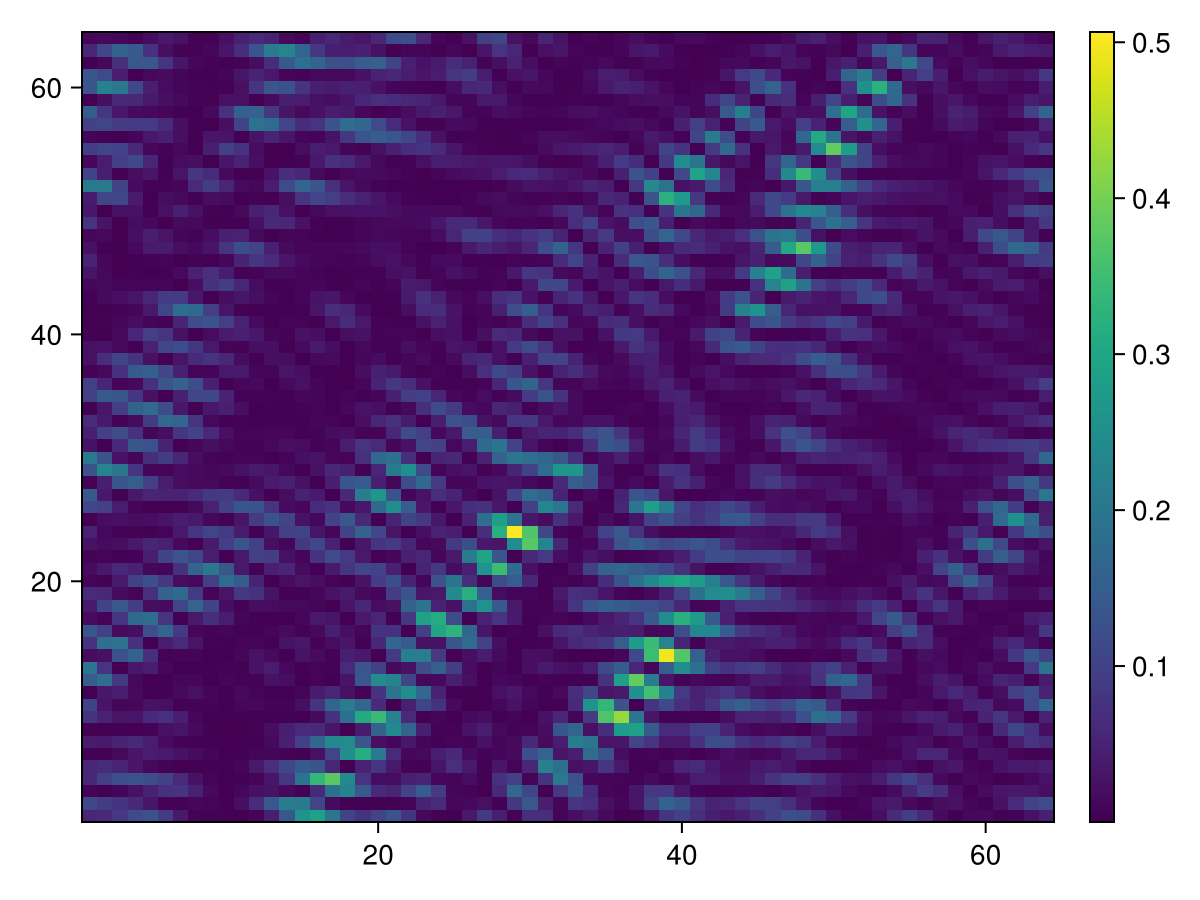

In [90]:
using CairoMakie

f = Figure()
ax = Axis(f[1, 1])
hm = heatmap!(ax, u.^2)

Colorbar(f[1, 2], hm)

f

In [96]:
sum(sqrt.(u.^2 + v.^2))/64/64

0.25980375545689804